# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Aprendizaje por refuerzos

### Trabajo práctico entregable 1/2 (materia completa)

**Estudiante:**
- [Chevallier-Boutell, Ignacio José.](https://www.linkedin.com/in/nachocheva/)

**Docentes:**
- Palombarini, Jorge (Mercado Libre).
- Barsce, Juan Cruz (Mercado Libre).

---

## Librerías

In [95]:
import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

Para ver los videos de las ejecuciones hay que tener instalado ffmpeg (`apt-get install ffmpeg`).

## Funciones predefinidas de ploteo

In [96]:
def plot_reward_per_episode(ep_return) -> None:
    episode_returns = np.array(ep_return)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_returns) + 1, len(episode_returns) + 1)
    acumulated_rewards = np.cumsum(episode_returns)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()

In [97]:
def plot_steps_per_episode(ep_timesteps) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(ep_timesteps)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title("Pasos (timesteps) por episodio")
    plt.show()

In [98]:
def plot_steps_per_episode_smooth(ep_timesteps) -> None:
    episode_steps = np.array(ep_timesteps)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.show()

In [99]:
def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

---
# Cliff walking

## Descripción del problema

Cliff walking es un juego que involucra moverse sobre un mapa (grilla 4x12) desde un punto inicial (Start, S) hasta un punto final (Goal, G), evitando caer por el precipicio (The Cliff).

![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

Imagen: Sutton y Barto, 2018.

Al comenzar un episodio, el jugador se ubica en el elemento [3, 0] de la grilla y debe llegar hasta el elemento [3, 11] para terminar dicho episodio. El precipio se ubica en [3, 1:11]. Cuando el jugador llega a uno de estos elementos, *se cae por el precipicio* y vuelve al punto inicial [3, 0]. El jugador debe realizar tantos movimientos como sean necesarios para llegar a la meta y finalizar el episodio.

El espacio de acciones $\mathcal{A}$ tiene 4 elementos:
- 0 $\Rightarrow$ Se mueve hacia arriba
- 1 $\Rightarrow$ Se mueve hacia la derecha
- 2 $\Rightarrow$ Se mueve hacia abajo
- 3 $\Rightarrow$ Se mueve hacia la izquierda

A pesar de que la grilla tiene 48 elementos, el jugador no puede estar en el precipicio, ya que vuelve al punto S, y tampoco puede estar en la meta, sino sólo llegar a ésta, ya que es el estado terminal del episodio. Esto resulta en que el espacio de estados $\mathcal{S}$ tiene 37 elementos. Para calcular el valor del estado asociado a cada elemento del mapa debemos calcular
    $$\text{Fila Actual} \times \text{Número de Columnas} + \text{Columna Actual}$$

donde debemos contar desde 0. De esta manera, el estado inicial es el estado 36.

Se cumple que $\mathcal{A}, \mathcal{S} \in \mathbb{N}$, teniendo al cero como primer elemento.

La función de recompensa es tal que el jugador recibe:
- $-100$ cuando cae el precipicio.
- $-1$ en todos los demás casos.

## Elementos del agente

### Heurísticas de selección de acciones: políticas

Se definen los métodos para decidir qué acciones tomar, pudiendo ser $\epsilon$-greedy o SoftMax.

In [100]:
def pol_e_greedy(state: int, 
                actions: range, 
                q: dict,
                hyperparameters: dict,
                random_state: np.random.RandomState
                ) -> int:

    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración-explotación épsilon-greedy
    """

    # Lista de valores q asociados a un estado-acción, inicializando con 0.0
    q_values = [q.get((state, a)) for a in actions]

    # Toma el valor máximo
    max_q = max(q_values)

    # Puede haber más de un valor máximo
    count = q_values.count(max_q)

    # Sortemaos un número aleatorio y comparamos con épsilon
    if random_state.uniform() < hyperparameters['epsilon']:
        # Exploramos, seleccionando una acción aleatoriamente
        return random_state.choice(actions)

    # Al no cumplirse la condición, explotamos
    elif count > 1:
        # Hay más de un valor máximo. Sorteamos alguno de ellos
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    
    else:
        # Hay un único valor máximo, eligiendo el correspondiente estado-acción
        i = q_values.index(max_q)

    return actions[i]

In [101]:
# def choose_action_softmax() -> int:
#     """
#     Elije una acción de acuerdo al aprendizaje realizado previamente
#     usando una política softmax
#     """

#     # TODO: implementar
#     pass

### Aprendizaje por diferencias temporales

Se definen los métodos de aprendizaje, los cuales toman una transición y cambian el diccionario de los valores de Q de acuerdo a Sarsa o Q-learning.

In [102]:
def dont_learn(state: Any,
               action: Any,
               reward: Any,
               next_state: Any,
               next_action: Any,
               hyperparameters: Any,
               q: Any,
               ) -> None:

    """
    No aprende nada, sino que simplemente progresa mediante la política elegida 
    de exploración-explotación.
    """

    pass

In [103]:
def learn_SARSA(state: int,
                action: int,
                reward: int,
                next_state: int,
                next_action: int,
                hyperparameters: dict,
                q: dict,
                ) -> None:

    """
    Realiza una actualización según el algoritmo SARSA, para una transición de 
    estado dada.
    Args:
        state: COMPLETAR
        action: COMPLETAR
        reward: COMPLETAR
        next_state: COMPLETAR
        next_action: COMPLETAR
        hyperparameters: COMPLETAR
        q: COMPLETAR
    """

    # Actualizo el valor del estado-acción
    Target = reward + hyperparameters['gamma']  * q[(next_state, next_action)]
    TD_error = Target - q[(state, action)]
    q[(state, action)] += hyperparameters['alpha'] * TD_error

    # Actualizo el estado
    state = next_state

    # Actualizo la acción
    action = next_action

    pass

In [104]:
# completar argumentos de la función para hacer una actualización Q-learning
def learn_Q_learning(
        # COMPLETAR
) -> None:
    """
    Realiza una actualización según el algoritmo Q-learning, para una transición
    de estado dada
    Args: COMPLETAR
    """

    # TODO - completa con tu código aquí

    pass

### Iteraciones

Definimos la manera en la que itera el algoritmo.

In [105]:
def run(learning_function: Callable, 
        hyperparameters: dict, 
        episodes_to_run: int, 
        env: gym.Env, 
        actions: range, 
        q: dict, 
        random_state: np.random.RandomState
        ) -> Tuple[np.ndarray, np.ndarray, int, int, int]:

    """
    Corre el algoritmo de RL para un dado entorno.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: entorno de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """

    # Registra la cantidad de pasos de cada episodio
    timesteps_of_episode = []

    # Registra el retorno de cada episodio
    return_of_episode = []

    # Cantidad máxima de pasos temporales
    max_iter = 2000

    # Casuísticas de finalización
    goal, drop, early = 0, 0, 0

    # Loop sobre los episodios
    for _ in range(episodes_to_run):
        # Instancea un nuevo agente en cada episodio
        # Fin del episodio: llegar a la salida o superar max_iter

        # Reinicia el entorno, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        # Retorno del episodio
        episode_return = 0

        # Contador de pasos temporales
        t = 0

        # Flag de finalización de iteración actual
        done = False

        # Elige la primera acción a ejecutar
        action = pol_e_greedy(state, 
                              actions, 
                              q, 
                              hyperparameters, 
                              random_state)

        while not done:
            # El agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Acumulamos recompensa
            episode_return += reward

            # Elige la nueva acción a ejecutar partiendo desde el nuevo estado
            next_action = pol_e_greedy(next_state, 
                                       actions, 
                                       q, 
                                       hyperparameters, 
                                       random_state)

            # Mecanismo de aprendizaje por TD
            # Aprendo con Sarsa
            learning_function(state,
                              action,
                              reward,
                              next_state,
                              next_action,
                              hyperparameters,
                              q)

            # Análisis de convergencia
            if terminated:
                # El agente alcanzó el objetivo
                goal += 1
                timesteps_of_episode = np.append(timesteps_of_episode, 
                                                 [int(t + 1)])
                # return_of_episode = np.append(return_of_episode, 
                #                               max(episode_return, -100))        # por qué hace esta comparación?
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True
            
            elif truncated:
                # El agente ejecutó una acción inválida
                drop += 1
                timesteps_of_episode = np.append(timesteps_of_episode, 
                                                 [int(t + 1)])
                # return_of_episode = np.append(return_of_episode, 
                #                               max(episode_return, -100))        # por qué hace esta comparación?
                return_of_episode = np.append(return_of_episode, episode_return)
                done = True

            # elif t < max_iter:
            #     # Quedan pasos disponibles
            #     print('')
            
            elif t >= max_iter:
                # Early stopping
                early += 1
                timesteps_of_episode = np.append(timesteps_of_episode, 
                                                 [int(t + 1)])
                return_of_episode = np.append(return_of_episode, 
                                              max(episode_return, -100))        # por qué hace esta comparación?
                # return_of_episode = np.append(return_of_episode, episode_return)
                done = True
                
            t += 1

    return timesteps_of_episode, return_of_episode, goal, drop, early

## Implementaciones

In [106]:
# env = gym.make("CliffWalking-v0", render_mode="human")
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

### Sarsa + $\epsilon$-greedy

In [107]:
learning_function = learn_SARSA
# learning_function = dont_learn

hyperparameters = {"alpha": 1, # "alpha": 0.5, 
                   "gamma": 1, 
                   "epsilon": 0.005, # "epsilon": 0.1, 
                   "tau": 25}

episodes_to_run = 500

# Valores para cada par (estado, acción), inicializados en 0.0
q = {}
for s in range(37):
    for a in range(4):
        q[(s, a)] = 0.0

# Semilla aleatoria
random_state = np.random.RandomState(1994)

In [108]:
ep_timesteps, ep_return, ep_goal, ep_drop, ep_early = run(learning_function,
                                                          hyperparameters,
                                                          episodes_to_run,
                                                          env,
                                                          actions,
                                                          q,
                                                          random_state)

env.close()

In [109]:
print(ep_goal, ep_drop, ep_early)

0 0 500


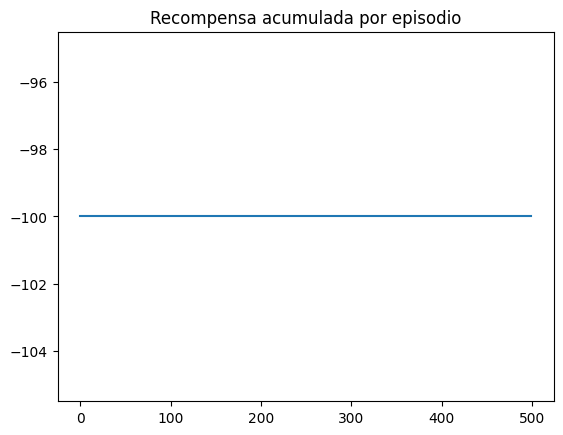

In [110]:
plot_reward_per_episode(ep_return)

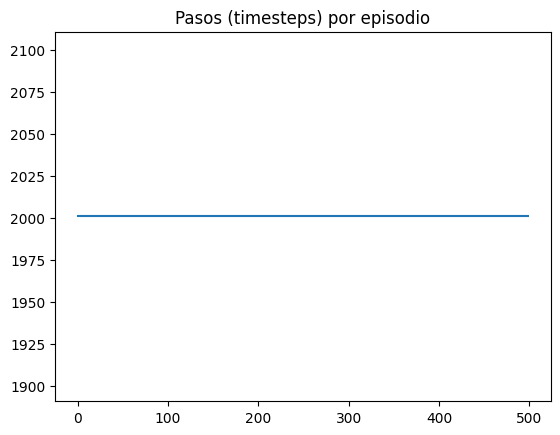

In [111]:
plot_steps_per_episode(ep_timesteps)

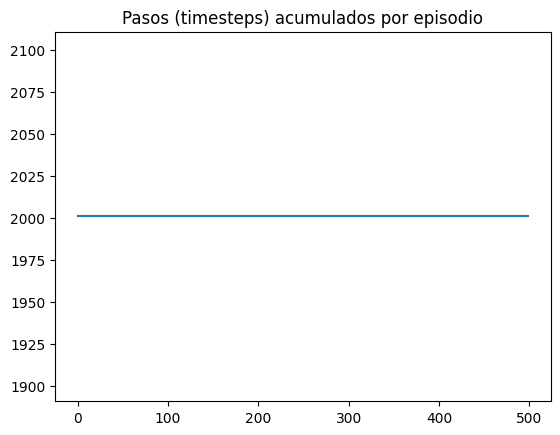

In [112]:
plot_steps_per_episode_smooth(ep_timesteps)

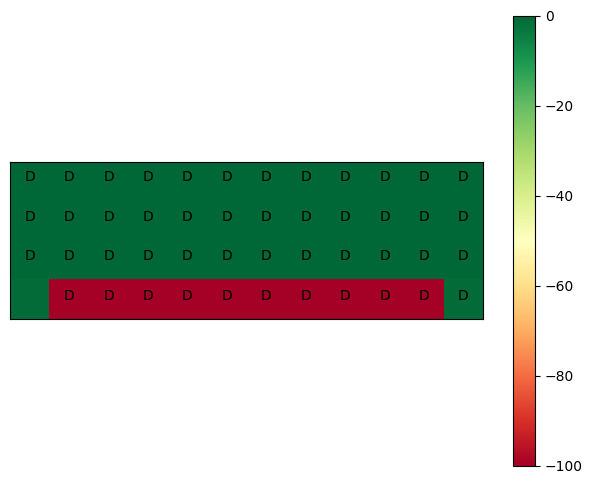


 Matriz de mejor acción-valor (en números): 

 [[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [  -1. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [113]:
draw_value_matrix(q)